### Part 1 
#### Objective: 
Build an NLP classification model to predict which brand a new product should be assigned.

#### Procedure:

1. Preprocessing: lemmatization; regex cleaning (remove punctutaion, stopwords)
2. Feature engineering: 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; a. Combine all the files: product, brand and two tags and form a full table: product_tag_brand; drop unnecessary columns
<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; b. Create new features by extracting strings from 'brand value' and description'

3. Vectorization: we have tried different methods: 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; a. count vectorization 
<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; b. tf-idf
<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; c. word embedding 

4. train/test split and modeling 
<br> The idea in this part is that we would like to try various models with different inputs and to see which one returns the highest accuarcy. 
<br> We chose to take top 50 brands and group everything else as other. And the Baseline performance accuracy for this model should be the largest value ~14.7%.

#### A. Count Vectorization: 
For the following models, we used count vectorization for feature extraction.
1. The mean accuracy with 10-fold cross-validation for logistic regression with only 'description' as predictor variable is 0.865. 
2. The accuracy for random forest with only 'description' as input is 0.877. 
3. The accuracy for neural network with only 'description' as input is 0.883. 
4. The accuracy for logistic regression with 'description','details', 'name', 'category' and 'attribute_pair' as inputs is 0.948
5. The accuracy for logistic regression withuse 'description','details', 'name', 'category', 'attribute_pair' and created features as inputs is 0.952. 

##### The highest accuracy we found when we employed count vectorization is 0.952. 

#### B. if-idf: 

- We have tried both bigram and unigram, and they do not predict well. We use 'description','details', 'name', 'category', 'attribute_pair' and created features as predictors. The accuracy given by logistic regression with OneVsRestClassifier (multiclass strategy) is 0.922. 

#### C. Word Embedding:
1. The accuracy for RNN with only 'description' as input is 0.770. 
2. The accuracy for LSTM with only 'description' as input is 0.844.
3. The accuracy for deep learning Neural Network with 'description','details', 'name', 'category' and 'attribute_pair' as inputs is 0.870. 
4. The accuracy for RNN with 'description','details', 'name', 'category' and 'attribute_pair' as inputs is 0.803. 
5. The accuracy for LSTM with 'description','details', 'name', 'category' and 'attribute_pair' as inputs is 0.928

#### Compiled Model after word embeding

- For the next model, we used 'description','details', 'name', 'category', 'attribute_pair' and created features. 
- We first combined the data, then preprocess the text input and categorical input separately. We put both inputs into the deep learning LSTM model. This complied model reached a test accuracy of 0.843.

#### Winner Model 
- Based on the multiple attempts presented previously, we found that DNN model performed the best after word-embedding. 
- We used 'description', 'name', 'details', 'attribute_pair', 'brand_category' as our predictor variables. 
- This model returned an accuracy of ~0.964. 

In [1]:
import pandas as pd
import numpy as np
import re
import spacy
from scipy.spatial.distance import cosine
import nltk
import string
from nltk import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import confusion_matrix

from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_val_score,KFold, StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from keras.preprocessing.text import Tokenizer
from typing import List
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from keras.layers.recurrent import SimpleRNN
from keras.layers import Flatten, Masking

from numpy import array, argmax, asarray, zeros

import keras
from keras.layers.recurrent import SimpleRNN, LSTM
from keras.layers import Flatten, Masking, Embedding
from keras.layers import Activation, Dense
from tensorflow.python.framework.ops import disable_eager_execution
from keras.models import Sequential                                       
from keras.utils.vis_utils import plot_model
from keras.layers import Input
from keras.layers.merge import Concatenate
from keras.models import Model

import warnings
warnings.filterwarnings('ignore')

# Load Dataset

## Product

In [2]:
%%time
# load product information
product = pd.read_excel('Behold+product+data+04262021.xlsx')
product.head(3)

CPU times: user 13.7 s, sys: 286 ms, total: 14 s
Wall time: 14.2 s


,product_id,brand,brand_category,name,details,created_at,brand_canonical_url,description,brand_description,brand_name,product_active
0,01EX0PN4J9WRNZH5F93YEX6QAF,Two,Unknown,Khadi Stripe Shirt-our signature shirt,NaN,2021-01-27 01:17:19.305 UTC,https://two-nyc.myshopify.com/products/white-k...,Our signature khadi shirt\navailable in black ...,Our signature khadi shirt\n\navailable in blac...,Khadi Stripe Shirt-our signature shirt,True
1,01F0C4SKZV6YXS3265JMC39NXW,Collina Strada,Unknown,RUFFLE MARKET DRESS LOOPY PINK SISTINE TOMATO,NaN,2021-03-09 18:43:10.457 UTC,https://collina-strada-2.myshopify.com/product...,Mid-length dress with ruffles and adjustable s...,Mid-length dress with ruffles and adjustable s...,RUFFLE MARKET DRESS LOOPY PINK SISTINE TOMATO,True
2,01EY4Y1BW8VZW51BWG5VZY82XW,Cariuma,Unknown,IBI Slip On Raw Red Knit Sneaker Women,NaN,2021-02-10 02:58:59.591 UTC,https://cariuma.myshopify.com/products/ibi-sli...,IBI Slip On Raw Red Knit Sneaker Women,IBI Slip On Raw Red Knit Sneaker Women,IBI Slip On Raw Red Knit Sneaker Women,False


In [3]:
product.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61355 entries, 0 to 61354
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   product_id           61355 non-null  object
 1   brand                61355 non-null  object
 2   brand_category       60896 non-null  object
 3   name                 61354 non-null  object
 4   details              9200 non-null   object
 5   created_at           61355 non-null  object
 6   brand_canonical_url  61355 non-null  object
 7   description          51238 non-null  object
 8   brand_description    51234 non-null  object
 9   brand_name           61354 non-null  object
 10  product_active       61355 non-null  bool  
dtypes: bool(1), object(10)
memory usage: 4.7+ MB


## Brand

In [4]:
# load brand information
brand = pd.read_csv('behold_brands USC.csv')
brand.head(3)

,brand_id,brand,brand_value,bio,quote,quote_attribute,intro,lifestyle_copy,short_bio,listing_bio
0,01ESKR0CH2KYC7KBNTN0S38EQA,Mari Giudicelli,Handmade / Artisan Crafted,NaN,NaN,NaN,NaN,NaN,NaN,Behold Mari Giudicelli! This Brazilian shoe de...
1,01ESKR0CH2KYC7KBNTN0S38EQA,Mari Giudicelli,Sustainable,NaN,NaN,NaN,NaN,NaN,NaN,Behold Mari Giudicelli! This Brazilian shoe de...
2,01ESKR0CH2KYC7KBNTN0S38EQA,Mari Giudicelli,Women Owned,NaN,NaN,NaN,NaN,NaN,NaN,Behold Mari Giudicelli! This Brazilian shoe de...


In [5]:
brand.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162 entries, 0 to 161
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   brand_id         162 non-null    object
 1   brand            162 non-null    object
 2   brand_value      154 non-null    object
 3   bio              157 non-null    object
 4   quote            157 non-null    object
 5   quote_attribute  154 non-null    object
 6   intro            154 non-null    object
 7   lifestyle_copy   156 non-null    object
 8   short_bio        157 non-null    object
 9   listing_bio      157 non-null    object
dtypes: object(10)
memory usage: 12.8+ KB


## Outfit

In [6]:
outfit = pd.read_csv('outfit_combinations USC.csv')
outfit.head(5)

,outfit_id,product_id,outfit_item_type,brand,product_full_name
0,01DDBHC62ES5K80P0KYJ56AM2T,01DMBRYVA2P5H24WK0HTK4R0A1,bottom,Eileen Fisher,Slim Knit Skirt
1,01DDBHC62ES5K80P0KYJ56AM2T,01DMBRYVA2PEPWFTT7RMP5AA1T,top,Eileen Fisher,Rib Mock Neck Tank
2,01DDBHC62ES5K80P0KYJ56AM2T,01DMBRYVA2S5T9W793F4CY41HE,accessory1,kate spade new york,medium margaux leather satchel
3,01DDBHC62ES5K80P0KYJ56AM2T,01DMBRYVA2ZFDYRYY5TRQZJTBD,shoe,Tory Burch,Penelope Mid Cap Toe Pump
4,01DMHCX50CFX5YNG99F3Y65GQW,01DMBRYVA2P5H24WK0HTK4R0A1,bottom,Eileen Fisher,Slim Knit Skirt


In [7]:
outfit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5291 entries, 0 to 5290
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   outfit_id          5291 non-null   object
 1   product_id         5291 non-null   object
 2   outfit_item_type   5291 non-null   object
 3   brand              5291 non-null   object
 4   product_full_name  5291 non-null   object
dtypes: object(5)
memory usage: 206.8+ KB


## Expert Tags

In [8]:
tags = pd.read_csv('usc_additional_tags USC.csv')
tags.head(3)

,product_id,product_color_id,attribute_name,attribute_value
0,01E5ZXP5H0BTEZT9QD2HRZJ47A,01E5ZXP5JCREDC7WJVMWHK5Q40,materialclothing,linenblend
1,01E5ZXP5H0BTEZT9QD2HRZJ47A,01E5ZXP5JCREDC7WJVMWHK5Q40,materialclothing,cottonblend
2,01E5ZXP5H0BTEZT9QD2HRZJ47A,01E5ZXP5JCREDC7WJVMWHK5Q40,style,modern


In [9]:
tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97420 entries, 0 to 97419
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   product_id        97420 non-null  object
 1   product_color_id  97420 non-null  object
 2   attribute_name    97420 non-null  object
 3   attribute_value   97420 non-null  object
dtypes: object(4)
memory usage: 3.0+ MB


# EDA

There is no duplicate product id in product.csv

In [10]:
len(product.product_id.unique())==len(product)

True

We have more brands in product.csv compared to brand.csv and outfit.csv

In [11]:
# number of unique brands in product.csv
len(product.brand.unique())

386

In [12]:
# number of unique brands in brand.csv
len(brand.brand.unique())

74

In [13]:
# number of unique brands in outfit.csv
len(outfit.brand.unique())

306

There are 6 different brand values which could be set as a new feature later on

In [14]:
brand.brand_value.value_counts()

Women Owned                   47
Emerging                      41
Handmade / Artisan Crafted    29
Sustainable                   27
BIPOC Owned                    6
Vegan                          4
Name: brand_value, dtype: int64

There are 7 different outfit item types, and five different outfit types:
- shoe
- accessory
- top
- bottom
- onepiece

In [15]:
outfit.outfit_item_type.value_counts()

shoe          1149
accessory1    1064
accessory2     978
top            950
bottom         928
onepiece       221
accessory3       1
Name: outfit_item_type, dtype: int64

There are 86 different attribute types, each type is assocaites with several values. Attributes could be added to features for different products later on.

In [16]:
len(tags.attribute_name.unique())

86

In [17]:
tags.attribute_name.value_counts()[:20]

style               14462
occasion            12624
materialclothing     5589
category             5522
primarycolor         5466
gender               5433
fit                  3814
sizing               3701
drycleanonly         3488
sleevelength         2619
additionalcolor      2572
neckline             2417
lengthtop            1837
pattern              1604
subcategorytop       1387
uppermaterial        1252
subcategoryshoe      1246
shoewidth            1221
toestyle             1217
closureshoe          1163
Name: attribute_name, dtype: int64

# Part 1: classification

**Problem Statement:**
>A common problem for Behold is the extremely manual classification of new products 
    into their specific brands. Behold has supplier relationships from many global clothing 
    vendors and marketplaces, but has found that the bottleneck for scaling out the number 
    of products they can sell is identifying the brands associated with each new product. Use 
    the brands’ biographical description (behold_brands.csv), product descriptions
    (products.csv) and any externally collected metadata, **build an NLP classification
    model to predict which brand a new product should be assigned**

**Solution Pipeline:**

1. Preprocess the text (e.g., lemmatization, grouping, tokenize)
2. Feature engineering (e.g., using tags, product attributes)
    - Feature creation
3. Vectorization (either via count vectorization or via embeddings)
4. train/test split and modeling (try different models and compare the performance)

## Preprocessing

In [18]:
%%time
## need to download 'en_core_web_lg' first
nlp = spacy.load('en_core_web_lg',disable=['ner','parser'])

CPU times: user 1.47 s, sys: 786 ms, total: 2.25 s
Wall time: 2.63 s


### lemmatization

In [19]:
def spacy_lem(data, field):
    '''
    do lemmatization for data[field]
    '''
    for i in range(len(data)):
        if type(data.loc[i,field])==str:
            rows = []
            doc = nlp(data.loc[i,field])
            for token in doc:
                rows.append(token.lemma_)
            data.loc[i,field] = ' '.join(rows)

In [21]:
%%time
for field in ['description','details','name','brand_category']:
    spacy_lem(product,field)

CPU times: user 16min 14s, sys: 25.7 s, total: 16min 40s
Wall time: 16min 50s


In [22]:
%%time
for field in brand.columns[2:]:
    spacy_lem(brand,field)

CPU times: user 4.49 s, sys: 121 ms, total: 4.61 s
Wall time: 4.64 s


In [23]:
product_cp = product.copy()
brand_cp = brand.copy()

### Regex Cleaning

In [24]:
def removePunctuation(text, punctuations=string.punctuation+"``"+"’"+"”"):
    words=nltk.word_tokenize(text)
    newWords = [word for word in words if word.lower() not in punctuations]
    cleanedText = " ".join(newWords)
    return cleanedText

In [25]:
nltk_stopwords = set(stopwords.words("English"))
def removeStopwords(text, stopwords=nltk_stopwords):
    words = nltk.word_tokenize(text)
    newWords = [word for word in words if word.lower() not in stopwords]
    cleanedText = " ".join(newWords)
    return cleanedText

In [26]:
%%time
for col in ['description','details']:
    product[col] = product[col].str.replace('\s\s',' ')
    product[col] = product[col].fillna('UNKNOWN_TOKEN')
    product[col] = product[col].apply(removePunctuation)
    product[col] = product[col].apply(removeStopwords)

for col in brand.columns[2:]:
    brand[col] = brand[col].str.replace('\s\s',' ')
    brand[col] = brand[col].fillna('UNKNOWN_TOKEN')
    brand[col] = brand[col].apply(removePunctuation)
    brand[col] = brand[col].apply(removeStopwords)

CPU times: user 43.4 s, sys: 118 ms, total: 43.5 s
Wall time: 43.6 s


## Feature Engineering

### Concatenating data

In [27]:
# put different brand values into one columns
df = brand.groupby('brand').agg({'brand_value':list}).reset_index().rename(columns = {'brand_value':'value_brand'})
df_brand = df.merge(brand,on='brand',how='left')[['brand', 'value_brand', 'bio', 'quote',
       'quote_attribute', 'intro', 'lifestyle_copy', 'short_bio',
       'listing_bio']]
df_brand.sample(3)

,brand,value_brand,bio,quote,quote_attribute,intro,lifestyle_copy,short_bio,listing_bio
15,Andrea Iyamah,"[woman, emerge, BIPOC]",Andrea Iyamah nigerian fashion designer Andrea...,design inspire Cultural Story,UNKNOWN_TOKEN,UNKNOWN_TOKEN,ARIFA High Waist Bikini SS20,design inspire Cultural Story,behold Andrea Iyamah Nigerian Toronto base swi...
156,Zonarch,"[sustainable, emerge, vegan, woman, Handmade A...",Zonarch swimwear brand dedicate change way hol...,sustainable California swimwear brand offer ha...,WWD,Zonarch go sustainably craft swim holiday esse...,Zonarch 's Coco top Laetitia Bottom Stripe,Á La Holiday,behold Zonarch swimwear brand fresh scene alre...
159,lemlem,"[sustainable, BIPOC, woman, Handmade Artisan C...",lemlem woman 's resort wear brand make entirel...,want inject energy fuel back artisan artisanal...,Liya Kebede,found 2007 Liya Kebede lemlem entirely make Et...,lemlem Zoya Tunic Dress,lemlem artisan drive resortwear brand make Africa,behold LemLem found unstoppable supermodel Liy...


In [28]:
# combine product and brand
product_brand = product.merge(df_brand,on='brand',how='left')
product_brand = product_brand.drop_duplicates(subset=['product_id'], keep='first', inplace=False).\
                reset_index().drop(columns=['index'])
product_brand.head(2)

,product_id,brand,brand_category,name,details,created_at,brand_canonical_url,description,brand_description,brand_name,product_active,value_brand,bio,quote,quote_attribute,intro,lifestyle_copy,short_bio,listing_bio
0,01EX0PN4J9WRNZH5F93YEX6QAF,Two,Unknown,Khadi Stripe Shirt-our signature shirt,UNKNOWN_TOKEN,2021-01-27 01:17:19.305 UTC,https://two-nyc.myshopify.com/products/white-k...,signature khadi shirt available black white ea...,Our signature khadi shirt\n\navailable in blac...,Khadi Stripe Shirt-our signature shirt,True,"[sustainable, Handmade Artisan Crafted, woman]",two modern minimalist take caftan tunic easy d...,two emphasize importance sustainable craftsman...,Monica Patel Cohn Designer founder,chic modern piece gorgeous handwoven fabric,think two feel certain energy bliss calm warmt...,art Sari,behold two founder Monica Patel Cohn launch fr...
1,01F0C4SKZV6YXS3265JMC39NXW,Collina Strada,Unknown,RUFFLE MARKET DRESS LOOPY PINK SISTINE TOMATO,UNKNOWN_TOKEN,2021-03-09 18:43:10.457 UTC,https://collina-strada-2.myshopify.com/product...,mid length dress ruffle adjustable strap bias ...,Mid-length dress with ruffles and adjustable s...,RUFFLE MARKET DRESS LOOPY PINK SISTINE TOMATO,True,"[woman, emerge]",well ready wear collection Collina Strada plat...,season season goal remain encourage self refle...,Hillary Taymour,Collina Strada platform social issue awareness...,Collina Strada embody humor youth brand dna fi...,easy wear clothe imbue fearlessly fluid attitude,behold Hillary Taymor master tie dye ethical w...


In [29]:
product_brand.shape

(61355, 19)

In [30]:
tags['attribute_pair']=tags['attribute_name']+": "+tags['attribute_value']
tags.head(1)

,product_id,product_color_id,attribute_name,attribute_value,attribute_pair
0,01E5ZXP5H0BTEZT9QD2HRZJ47A,01E5ZXP5JCREDC7WJVMWHK5Q40,materialclothing,linenblend,materialclothing: linenblend


In [31]:
tag_combined = tags.groupby('product_id').agg({'attribute_pair':list}).reset_index()
tag_combined.sample(3)

,product_id,attribute_pair
2187,01E2M3R94F8RHX3HJH75PP52BM,"[pattern: logo, primarycolor: lightbrowns, mat..."
3030,01E4RTTHB2BFZGSR3FZR503ZH1,"[primarycolor: blacks, style: modern, material..."
988,01E2FDK4K4BP3WYYW8YKAHTEYX,"[primarycolor: blacks, style: edgy, materialcl..."


In [32]:
product_tag_brand = product_brand.merge(tag_combined,on='product_id',how='left')
product_tag_brand = product_tag_brand.drop(columns=['created_at',
                                                    'brand_canonical_url','brand_description',
                                                    'brand_name','product_active'
                                                   ])
product_tag_brand.isna().sum()

product_id             0
brand                  0
brand_category       459
name                   1
details                0
description            0
value_brand        18680
bio                18680
quote              18680
quote_attribute    18680
intro              18680
lifestyle_copy     18680
short_bio          18680
listing_bio        18680
attribute_pair     57575
dtype: int64

In [33]:
product_tag_brand.shape

(61355, 15)

In [34]:
product_tag_brand = product_tag_brand.fillna('UNKNOWN_TOKEN')

### Feature Creation

In [35]:
product_tag_brand.head(3)

,product_id,brand,brand_category,name,details,description,value_brand,bio,quote,quote_attribute,intro,lifestyle_copy,short_bio,listing_bio,attribute_pair
0,01EX0PN4J9WRNZH5F93YEX6QAF,Two,Unknown,Khadi Stripe Shirt-our signature shirt,UNKNOWN_TOKEN,signature khadi shirt available black white ea...,"[sustainable, Handmade Artisan Crafted, woman]",two modern minimalist take caftan tunic easy d...,two emphasize importance sustainable craftsman...,Monica Patel Cohn Designer founder,chic modern piece gorgeous handwoven fabric,think two feel certain energy bliss calm warmt...,art Sari,behold two founder Monica Patel Cohn launch fr...,UNKNOWN_TOKEN
1,01F0C4SKZV6YXS3265JMC39NXW,Collina Strada,Unknown,RUFFLE MARKET DRESS LOOPY PINK SISTINE TOMATO,UNKNOWN_TOKEN,mid length dress ruffle adjustable strap bias ...,"[woman, emerge]",well ready wear collection Collina Strada plat...,season season goal remain encourage self refle...,Hillary Taymour,Collina Strada platform social issue awareness...,Collina Strada embody humor youth brand dna fi...,easy wear clothe imbue fearlessly fluid attitude,behold Hillary Taymor master tie dye ethical w...,UNKNOWN_TOKEN
2,01EY4Y1BW8VZW51BWG5VZY82XW,Cariuma,Unknown,IBI Slip On Raw Red Knit Sneaker Women,UNKNOWN_TOKEN,ibi slip Raw Red Knit Sneaker woman,"[BIPOC, emerge, Handmade Artisan Crafted, sust...",embrace personal style status quo trend empowe...,CARIUMA end search truly sustainable ultra com...,forbe,believe style comfort sustainability synonymou...,CARIUMA sustainability style comfort synonymou...,believe make thing way well people planet,behold Cariuma brazilian brand found good frie...,UNKNOWN_TOKEN


In [36]:
# manufacturing location features
pd.set_option('display.max_rows', 30)
location = product_tag_brand['description'].str.\
       extract(r'\b(?:made|make)\s?(?:in)?\s?(?!Lark|Organic|Cardigan|Charli|ATM|Holiday|Fall|Far)([A-Z]\w+\s?(?!Dry|Emeline|Michelle|Stretch|Models?|Style|Fit|Cotton|Swim|Crown|Madeleine|Phoebe|Limited|Army|Ally|Width|Knitted|Embossed|Regular|Ella|Micro)(?:[A-Z][a-z]\w+)?)\b')
product_tag_brand['manuf_location'] = location[0]

In [37]:
# change from list to str
product_tag_brand['value_brand'] = [" ".join(i) if i!='UNKNOWN_TOKEN' else 'UNKNOWN_TOKEN' for i in product_tag_brand['value_brand']]

In [38]:
# brand value features （!!could only be used for part 2 problem）
product_tag_brand['is_handmade'] = ~pd.isna(product_tag_brand['value_brand'].str.extract(r'\b(Handmade)\b'))
product_tag_brand['is_artisan_crafted'] = ~pd.isna(product_tag_brand['value_brand'].str.extract(r'\b(Artisan Crafted)\b'))
product_tag_brand['is_sustainable'] = ~pd.isna(product_tag_brand['value_brand'].str.extract(r'\b(sustainable)\b'))
product_tag_brand['is_emerging'] = ~pd.isna(product_tag_brand['value_brand'].str.extract(r'\b(emerge)\b'))
product_tag_brand['is_vegan'] = ~pd.isna(product_tag_brand['value_brand'].str.extract(r'\b(Vegan)\b'))
product_tag_brand['is_BIPOC'] = ~pd.isna(product_tag_brand['value_brand'].str.extract(r'\b(BIPOC)\b'))
product_tag_brand['is_woman_owned'] = ~pd.isna(product_tag_brand['value_brand'].str.extract(r'\b(woman)\b'))

In [39]:
# change from list to str
product_tag_brand['attribute_pair'] = [" ".join(i) if i!='UNKNOWN_TOKEN' else 'UNKNOWN_TOKEN' for i in product_tag_brand['attribute_pair']]

In [40]:
# occassion features
product_tag_brand['is_beach'] = ~pd.isna(product_tag_brand['description'].str.extract(r'\b(beach)\b')) + (~pd.isna(product_tag_brand['details'].str.extract(r'\b(beach)\b')))
product_tag_brand['is_city'] = pd.notna(product_tag_brand['description'].str.extract(r'\b(city)\b')) + pd.notna(product_tag_brand['details'].str.extract(r'\b(city)\b'))
product_tag_brand['is_holiday'] = pd.notna(product_tag_brand['description'].str.extract(r'\b((?:vacation|holiday|getaway|weekend))\b')) + pd.notna(product_tag_brand['details'].str.extract(r'\b((?:vacation|holiday|getaway|weekend))\b'))
product_tag_brand['is_romance'] = pd.notna(product_tag_brand['description'].str.extract(r'\b((?:romantic|romance))\b')) + pd.notna(product_tag_brand['details'].str.extract(r'\b((?:romantic|romance))\b'))
product_tag_brand['is_chic'] = pd.notna(product_tag_brand['description'].str.extract(r'\b(chic)\b')) + pd.notna(product_tag_brand['details'].str.extract(r'\b(chic)\b'))
product_tag_brand['is_comfortable'] = pd.notna(product_tag_brand['description'].str.extract(r'\b((?:comfort|cozy))\b')) + pd.notna(product_tag_brand['details'].str.extract(r'\b((?:comfort|cozy))\b'))
product_tag_brand['is_weekday'] = pd.notna(product_tag_brand['description'].str.extract(r'\b((?:weekday))\b')) + pd.notna(product_tag_brand['details'].str.extract(r'\b((?:weekday))\b'))
product_tag_brand['is_asymmetrical'] = pd.notna(product_tag_brand['description'].str.extract(r'\b((?:asymmetrical))\b')) + pd.notna(product_tag_brand['details'].str.extract(r'\b((?:asymmetrical))\b'))
product_tag_brand['is_timeless'] = pd.notna(product_tag_brand['description'].str.extract(r'\b((?:timeless))\b')) + pd.notna(product_tag_brand['details'].str.extract(r'\b((?:timeless))\b'))
product_tag_brand['is_classic'] = pd.notna(product_tag_brand['description'].str.extract(r'\b((?:classics?))\b')) + pd.notna(product_tag_brand['details'].str.extract(r'\b((?:classics?))\b'))
product_tag_brand['is_swim'] = pd.notna(product_tag_brand['description'].str.extract(r'\b((?:swim|swimming))\b')) + pd.notna(product_tag_brand['details'].str.extract(r'\b((?:swim|swimming))\b'))
product_tag_brand['is_casual'] = pd.notna(product_tag_brand['description'].str.extract(r'\b((?:casual))\b')) + pd.notna(product_tag_brand['details'].str.extract(r'\b((?:casual))\b'))
product_tag_brand['is_pajama'] = pd.notna(product_tag_brand['description'].str.extract(r'\b((?:pajama))\b')) + pd.notna(product_tag_brand['details'].str.extract(r'\b((?:pajama))\b'))
product_tag_brand['is_sophisticated'] = pd.notna(product_tag_brand['description'].str.extract(r'\b((?:sophisticated?))\b')) + pd.notna(product_tag_brand['details'].str.extract(r'\b((?:sophisticated?))\b'))
product_tag_brand['is_modern'] = pd.notna(product_tag_brand['description'].str.extract(r'\b((?:modern|contemporary))\b')) + pd.notna(product_tag_brand['details'].str.extract(r'\b((?:modern|contemporary))\b'))

In [41]:
# material features
pd.set_option('display.max_rows', 30)
material = product_tag_brand['description'].str.extract(r'\b(100\s\w+)\b')
product_tag_brand['material'] = material[0].str.lower()

In [42]:
product_tag_brand.sample(3)

,product_id,brand,brand_category,name,details,description,value_brand,bio,quote,quote_attribute,...,is_weekday,is_asymmetrical,is_timeless,is_classic,is_swim,is_casual,is_pajama,is_sophisticated,is_modern,material
34740,01EYQ1F5CY3PD0ZVPNBPV96SY1,Rails,Unknown,TAYLIN - BLACK,UNKNOWN_TOKEN,details heavy knit jersey pure cotton sleevele...,UNKNOWN_TOKEN,innovative shirt propel Rails contemporary mar...,collection blend effortless ease California ro...,Jeff Abrams,...,False,False,False,False,False,False,False,False,False,100 cotton
50228,01EEBGRDRN3GCGN2E53ZAW5D5F,Intentionally Blank,Unknown,ARCHIVE 1353,UNKNOWN_TOKEN,UNKNOWN_TOKEN,UNKNOWN_TOKEN,intentionally create 2014 Los Angeles currentl...,intentionally fill wardrobe footwear closet st...,Ty McBride Founder Creative Director,...,False,False,False,False,False,False,False,False,False,NaN
12957,01ENBK2KB7K3BB56C48SYP6XEE,Rails,Unknown,HESTON - REVERSIBLE OLIVE HEATHER GREY STRIPE,UNKNOWN_TOKEN,details cozy brush fleece double faced long sl...,UNKNOWN_TOKEN,innovative shirt propel Rails contemporary mar...,collection blend effortless ease California ro...,Jeff Abrams,...,False,False,True,True,False,False,False,False,False,100 cotton


### Grouping

In [43]:
# 'manuf_location'
product_tag_brand.manuf_location = product_tag_brand.manuf_location.str.replace(r'\bLA\b','Los Angeles')
product_tag_brand.manuf_location = product_tag_brand.manuf_location.str.replace(r'\bNY｜NYC\b','New York')
product_tag_brand.manuf_location = product_tag_brand.manuf_location.str.replace(r'\bUS\b','USA')
product_tag_brand.manuf_location = product_tag_brand.manuf_location.str.replace(r'\bItalian|ItalySmall\b','Italy')
product_tag_brand.manuf_location = product_tag_brand.manuf_location.str.replace(r'\bCN\b','China')

In [45]:
df=product_tag_brand.copy()

In [46]:
df.fillna('UNKNOWN_TOKEN',inplace=True)
df.brand = df.brand.astype(str)

In [47]:
df.brand_category = df.brand_category.str.replace('Unknown','UNKNOWN_TOKEN')
df.head()

,product_id,brand,brand_category,name,details,description,value_brand,bio,quote,quote_attribute,...,is_weekday,is_asymmetrical,is_timeless,is_classic,is_swim,is_casual,is_pajama,is_sophisticated,is_modern,material
0,01EX0PN4J9WRNZH5F93YEX6QAF,Two,UNKNOWN_TOKEN,Khadi Stripe Shirt-our signature shirt,UNKNOWN_TOKEN,signature khadi shirt available black white ea...,sustainable Handmade Artisan Crafted woman,two modern minimalist take caftan tunic easy d...,two emphasize importance sustainable craftsman...,Monica Patel Cohn Designer founder,...,False,False,False,False,False,False,False,False,False,UNKNOWN_TOKEN
1,01F0C4SKZV6YXS3265JMC39NXW,Collina Strada,UNKNOWN_TOKEN,RUFFLE MARKET DRESS LOOPY PINK SISTINE TOMATO,UNKNOWN_TOKEN,mid length dress ruffle adjustable strap bias ...,woman emerge,well ready wear collection Collina Strada plat...,season season goal remain encourage self refle...,Hillary Taymour,...,False,False,False,False,False,False,False,False,False,100 rose
2,01EY4Y1BW8VZW51BWG5VZY82XW,Cariuma,UNKNOWN_TOKEN,IBI Slip On Raw Red Knit Sneaker Women,UNKNOWN_TOKEN,ibi slip Raw Red Knit Sneaker woman,BIPOC emerge Handmade Artisan Crafted sustainable,embrace personal style status quo trend empowe...,CARIUMA end search truly sustainable ultra com...,forbe,...,False,False,False,False,False,False,False,False,False,UNKNOWN_TOKEN
3,01EY50E27A0P5V6KCW01XPDB43,Cariuma,UNKNOWN_TOKEN,IBI Slip On Black Knit Sneaker Women,UNKNOWN_TOKEN,ibi slip Black Knit Sneaker woman,BIPOC emerge Handmade Artisan Crafted sustainable,embrace personal style status quo trend empowe...,CARIUMA end search truly sustainable ultra com...,forbe,...,False,False,False,False,False,False,False,False,False,UNKNOWN_TOKEN
4,01EY6DWHC2W5HPNEGXKEJ4A1CX,Cariuma,UNKNOWN_TOKEN,CATIBA PRO Skate Black Suede and Canvas Contra...,UNKNOWN_TOKEN,UNKNOWN_TOKEN,BIPOC emerge Handmade Artisan Crafted sustainable,embrace personal style status quo trend empowe...,CARIUMA end search truly sustainable ultra com...,forbe,...,False,False,False,False,False,False,False,False,False,UNKNOWN_TOKEN


In [49]:
df.to_csv('after_feature_creation.csv',index=None)

In [2]:
df = pd.read_csv('after_feature_creation.csv')

### Onehot encoding

In [3]:
# one-hot encoding
combined = pd.get_dummies(df[['manuf_location', 'is_beach', 'is_city', 'is_holiday',
       'is_romance', 'is_chic', 'is_comfortable', 'is_weekday',
       'is_asymmetrical', 'is_timeless', 'is_classic', 'is_swim', 'is_casual',
       'is_pajama', 'is_sophisticated', 'is_modern', 'material']])

In [4]:
onehot_df = np.concatenate([df[['brand']],combined],axis=1)

In [5]:
combined.shape

(61355, 686)

## Vectorization

### Count Vectorization

In [3]:
df.head(3)

,product_id,brand,brand_category,name,details,description,value_brand,bio,quote,quote_attribute,...,is_weekday,is_asymmetrical,is_timeless,is_classic,is_swim,is_casual,is_pajama,is_sophisticated,is_modern,material
0,01EX0PN4J9WRNZH5F93YEX6QAF,Two,UNKNOWN_TOKEN,Khadi Stripe Shirt-our signature shirt,UNKNOWN_TOKEN,signature khadi shirt available black white ea...,sustainable Handmade Artisan Crafted woman,two modern minimalist take caftan tunic easy d...,two emphasize importance sustainable craftsman...,Monica Patel Cohn Designer founder,...,False,False,False,False,False,False,False,False,False,UNKNOWN_TOKEN
1,01F0C4SKZV6YXS3265JMC39NXW,Collina Strada,UNKNOWN_TOKEN,RUFFLE MARKET DRESS LOOPY PINK SISTINE TOMATO,UNKNOWN_TOKEN,mid length dress ruffle adjustable strap bias ...,woman emerge,well ready wear collection Collina Strada plat...,season season goal remain encourage self refle...,Hillary Taymour,...,False,False,False,False,False,False,False,False,False,100 rose
2,01EY4Y1BW8VZW51BWG5VZY82XW,Cariuma,UNKNOWN_TOKEN,IBI Slip On Raw Red Knit Sneaker Women,UNKNOWN_TOKEN,ibi slip Raw Red Knit Sneaker woman,BIPOC emerge Handmade Artisan Crafted sustainable,embrace personal style status quo trend empowe...,CARIUMA end search truly sustainable ultra com...,forbe,...,False,False,False,False,False,False,False,False,False,UNKNOWN_TOKEN


In [4]:
df_text = df['description']
vectorizer_2 = CountVectorizer(ngram_range=(1, 1), 
                             stop_words="english", 
                             max_features=300,
                             min_df=2,
                             token_pattern='(?u)\\b[a-zA-Z][a-zA-Z]+\\b')

### TF-IDF

In [58]:
tf_idf_sm = TfidfVectorizer(ngram_range=(1,1),
                             token_pattern=r'\b[a-zA-Z]{3,}\b',
                             max_features=300,
                             min_df=2,
                             max_df=0.4, stop_words="english")
tf_idf_lg = TfidfVectorizer(ngram_range=(2,3),
                             token_pattern=r'\b[a-zA-Z]{3,}\b',
                             max_features=300,
                             min_df=2,
                             max_df=0.4, stop_words="english")

### Word embedding

In [9]:
# e.g. docs = df['description']
# using glove.txt
def word_embedding(docs):
    '''
    input: docs (e.g., df['description']) needed to do word embedding
    output: corresponding vectors
    '''
    # Tokenize the Text
    tokenizer = Tokenizer(num_words=10000, oov_token="UNKNOWN_TOKEN")
    tokenizer.fit_on_texts(docs)

    # Integer Encode Tokens
    def integer_encode_documents(docs, tokenizer):
        return tokenizer.texts_to_sequences(docs)

    # Get Max Length Per Token
    def get_max_token_length_per_doc(docs: List[List[str]])-> int:
        return max(list(map(lambda x: len(x.split()), docs)))
    ## get the max length in terms of token length
    max_length = get_max_token_length_per_doc(docs)

    MAX_SEQUENCE_LENGTH = 300
    ## integer encode the documents
    encoded_docs = integer_encode_documents(docs, tokenizer)
    ## this is a list of lists, the numbers represent the index position of that word.
    ## for instance, 33 means the 33rd word in the vocabulary
    padded_docs = pad_sequences(encoded_docs, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
    
    def load_glove_vectors():
        embeddings_index = {}
        with open('glove.6B.100d.txt') as f:
            for line in f:
                values = line.split()
                word = values[0]
                coefs = asarray(values[1:], dtype='float32')
                embeddings_index[word] = coefs
        print('Loaded %s word vectors.' % len(embeddings_index))
        return embeddings_index
    embeddings_index = load_glove_vectors()
    
    VOCAB_SIZE = int(len(tokenizer.word_index) * 1.1)
    
    # create a weight matrix for words in training docs
    embedding_matrix = zeros((VOCAB_SIZE, 100))
    for word, i in tokenizer.word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: # check that it is an actual word that we have embeddings for
            embedding_matrix[i] = embedding_vector    

    
    return tokenizer, padded_docs, embedding_matrix, MAX_SEQUENCE_LENGTH

In [10]:
# don't use pre-trained embeddings
def word_embedding_2(docs):
    '''
    input: docs (e.g., df['description','details']) needed to do word embedding
    output: corresponding vectors
    '''
    # Tokenize the Text
    tokenizer = Tokenizer(num_words=10000, oov_token="UNKNOWN_TOKEN")
    tokenizer.fit_on_texts(docs)

    # Integer Encode Tokens
    def integer_encode_documents(docs, tokenizer):
        return tokenizer.texts_to_sequences(docs)

    # Get Max Length Per Token
    def get_max_token_length_per_doc(docs: List[List[str]])-> int:
        return max(list(map(lambda x: len(x.split()), docs)))
    ## get the max length in terms of token length
    max_length = get_max_token_length_per_doc(docs)

    MAX_SEQUENCE_LENGTH = 300
    ## integer encode the documents
    encoded_docs = integer_encode_documents(docs, tokenizer)
    ## this is a list of lists, the numbers represent the index position of that word.
    ## for instance, 33 means the 33rd word in the vocabulary
    padded_docs = pad_sequences(encoded_docs, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
    
    return tokenizer, padded_docs, MAX_SEQUENCE_LENGTH

## Modeling

In [5]:
df_copy = df.copy()

In [6]:
# before assigining 'other' category for brand
df['brand'].value_counts(normalize=True)[:50]

7 For All Mankind        0.146867
Rails                    0.046679
Intentionally Blank      0.041301
A.L.C.                   0.034097
Rachel Comey             0.033917
Misa                     0.033086
Studio 189               0.031880
ASTR the Label           0.031652
lemlem                   0.029680
Simon Miller             0.023649
Cynthia Rowley           0.021954
Outerknown               0.021808
Chufy                    0.019705
Faherty                  0.019624
M.M.LaFleur              0.019428
Janessa Leone            0.018238
Araks                    0.017619
Sea                      0.017162
BROCHU WALKER            0.016315
Tanya Taylor             0.016152
Clare V.                 0.015027
Nili Lotan               0.011686
Les Girls Les Boys       0.011328
Prism                    0.010871
Sandy Liang              0.010806
6397                     0.010627
Ancient Greek Sandals    0.010073
Alo Yoga                 0.008557
Collina Strada           0.008166
Whit          

In [6]:
top50 = df['brand'].value_counts(normalize=True)[:50].index
def intop50(df):
    updatebrand = []
    for brand in df:
        if brand not in top50:
            updatebrand.append('other')
        else:
            updatebrand.append(brand)
    return updatebrand

Before we start training, let's take a look at the relative distribution of counts for cities. Baseline performance accuracy for this model should be the largest value **~14.7%**. You can get this accuracy by predicting the model.

In [7]:
df['brand'] = intop50(df['brand'])
df['brand'].value_counts(normalize=True)

7 For All Mankind        0.146867
other                    0.142515
Rails                    0.046679
Intentionally Blank      0.041301
A.L.C.                   0.034097
Rachel Comey             0.033917
Misa                     0.033086
Studio 189               0.031880
ASTR the Label           0.031652
lemlem                   0.029680
Simon Miller             0.023649
Cynthia Rowley           0.021954
Outerknown               0.021808
Chufy                    0.019705
Faherty                  0.019624
M.M.LaFleur              0.019428
Janessa Leone            0.018238
Araks                    0.017619
Sea                      0.017162
BROCHU WALKER            0.016315
Tanya Taylor             0.016152
Clare V.                 0.015027
Nili Lotan               0.011686
Les Girls Les Boys       0.011328
Prism                    0.010871
Sandy Liang              0.010806
6397                     0.010627
Ancient Greek Sandals    0.010073
Alo Yoga                 0.008557
Collina Strada

In [8]:
labels = df['brand']
encoder = LabelEncoder()
labels_encoded = to_categorical(encoder.fit_transform(labels))

### After Count Vectorization: 95.16%

#### use 'description' only

In [9]:
vectorizer = CountVectorizer(ngram_range=(1, 1), 
                             stop_words="english", 
                             max_features=1000,token_pattern='(?u)\\b[a-zA-Z][a-zA-Z]+\\b')

In [10]:
labels = df['brand']
df_text = df['description']
X_cntVec = vectorizer.fit_transform(df_text)
y = labels
X_cntVec

<61355x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 1253040 stored elements in Compressed Sparse Row format>

In [11]:
pd.DataFrame(X_cntVec.toarray().transpose(), index=vectorizer.get_feature_names())

,0,1,2,3,4,5,6,7,8,9,...,61345,61346,61347,61348,61349,61350,61351,61352,61353,61354
abstract,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
accent,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
accentuate,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
accept,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
accessory,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
yellow,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
yoke,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
york,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
zip,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


##### Logistic Regression

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_cntVec, labels, test_size=0.2, stratify = labels)
lr = OneVsRestClassifier(LogisticRegression(penalty='l2'))
lr.fit(X_train, y_train)

OneVsRestClassifier(estimator=LogisticRegression())

In [12]:
lr.score(X_test,y_test)

0.861461983538424

In [15]:
%%time
# cross validation
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=10)
lr = OneVsRestClassifier(LogisticRegression(penalty='l2'))
cv = cross_val_score(lr,X_cntVec,labels,cv=kfold,scoring='accuracy')
cv.mean()

CPU times: user 2min 17s, sys: 772 ms, total: 2min 17s
Wall time: 2min 17s


0.8647542208182049

In [12]:
# use fewer features
X_cntVec_sm = vectorizer_2.fit_transform(df_text)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_cntVec_sm, labels, test_size=0.2, stratify = labels)
lr_sm = OneVsRestClassifier(LogisticRegression(penalty='l2'))
lr_sm.fit(X_train, y_train)
lr_sm.score(X_test,y_test)

0.8059652840029338

##### Random Forest

In [16]:
%%time
rf = OneVsRestClassifier(RandomForestClassifier())
rf.fit(X_train,y_train)
rf.score(X_test,y_test)

CPU times: user 5min 59s, sys: 1.01 s, total: 6min
Wall time: 6min


0.8767011653491973

##### Neural Network

In [17]:
%%time
nn = OneVsRestClassifier(MLPClassifier())
nn.fit(X_train,y_train)
nn.score(X_test,y_test)

CPU times: user 32min 50s, sys: 3min 5s, total: 35min 56s
Wall time: 9min


0.8833835873196968

#### use 'description','details', 'name', 'category' and 'attribute_pair'

In [18]:
X_cntVec_2_1 = vectorizer_2.fit_transform(df['details'])
X_cntVec_2_2 = vectorizer_2.fit_transform(df['attribute_pair'])
X_cntVec_2_3 = vectorizer_2.fit_transform(df['name'])
X_cntVec_2_4 = vectorizer_2.fit_transform(df['brand_category'])

In [19]:
X_cntVec_2 = np.concatenate([X_cntVec_2_1.toarray(),X_cntVec_2_2.toarray(),X_cntVec.toarray(),X_cntVec_2_3.toarray(),X_cntVec_2_4.toarray()],axis=1)

In [20]:
X_cntVec_2.shape

(61355, 2129)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X_cntVec_2, labels, test_size=0.2, stratify = labels)

##### Logistic Regression

In [22]:
lr = OneVsRestClassifier(LogisticRegression(penalty='l2'))
lr.fit(X_train, y_train)

OneVsRestClassifier(estimator=LogisticRegression())

In [23]:
lr.score(X_test,y_test)

0.9484149621057778

In [ ]:
%%time
# cross validation
cv = cross_val_score(lr,X_cntVec_2,labels,cv=kfold,scoring='accuracy')
cv.mean()

#### use the created features only

In [25]:
df.columns

Index(['product_id', 'brand', 'brand_category', 'name', 'details',
       'description', 'value_brand', 'bio', 'quote', 'quote_attribute',
       'intro', 'lifestyle_copy', 'short_bio', 'listing_bio', 'attribute_pair',
       'manuf_location', 'is_handmade', 'is_artisan_crafted', 'is_sustainable',
       'is_emerging', 'is_vegan', 'is_BIPOC', 'is_woman_owned', 'is_beach',
       'is_city', 'is_holiday', 'is_romance', 'is_chic', 'is_comfortable',
       'is_weekday', 'is_asymmetrical', 'is_timeless', 'is_classic', 'is_swim',
       'is_casual', 'is_pajama', 'is_sophisticated', 'is_modern', 'material'],
      dtype='object')

In [26]:
# one-hot encoding
combined = pd.get_dummies(df[['manuf_location', 'is_beach', 'is_city', 'is_holiday',
       'is_romance', 'is_chic', 'is_comfortable', 'is_weekday',
       'is_asymmetrical', 'is_timeless', 'is_classic', 'is_swim', 'is_casual',
       'is_pajama', 'is_sophisticated', 'is_modern', 'material']])

In [27]:
combined.head(3)

,is_beach,is_city,is_holiday,is_romance,is_chic,is_comfortable,is_weekday,is_asymmetrical,is_timeless,is_classic,...,material_100 watersnake,material_100 weave,material_100 white,material_100 wood,material_100 wool,material_100 woolproduct,material_100 year,material_100 yummy,material_100 ï,material_UNKNOWN_TOKEN
0,True,True,False,False,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,1
1,False,False,False,False,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0
2,False,False,False,False,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,1


In [28]:
X_train, X_test, y_train, y_test = train_test_split(combined, labels, test_size=0.2, stratify = labels)

##### Logistic Regression

In [29]:
%%time
lr = OneVsRestClassifier(LogisticRegression(penalty='l2'))
lr.fit(X_train, y_train)
lr.score(X_test,y_test)

CPU times: user 6min 44s, sys: 31.4 s, total: 7min 16s
Wall time: 2min 56s


0.4109689511857224

##### Random Forest

In [33]:
# %%time
# rf = OneVsRestClassifier(RandomForestClassifier())
# rf.fit(X_train,y_train)
# rf.score(X_test,y_test)

#### use 'description','details', 'name', 'category', 'attribute_pair' and created features

In [34]:
X_cntVec_4 = np.concatenate([X_cntVec_2,combined],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X_cntVec_4, labels, test_size=0.2, stratify = labels)

In [35]:
X_train.shape

(49084, 2815)

In [36]:
%%time
lr = OneVsRestClassifier(LogisticRegression(penalty='l2'))
lr.fit(X_train, y_train)
lr.score(X_test,y_test)

CPU times: user 17min 44s, sys: 35.5 s, total: 18min 20s
Wall time: 6min 55s


0.9515931871893081

### After TF-IDF: 92.18%

#### use 'description' only

In [59]:
# unigram
X_tf_idf_sm = tf_idf_sm.fit_transform(df_text)

In [60]:
pd.DataFrame(X_tf_idf_sm.toarray().transpose(), index=tf_idf_sm.get_feature_names())

,0,1,2,3,4,5,6,7,8,9,...,61345,61346,61347,61348,61349,61350,61351,61352,61353,61354
acrylic,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
add,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
adjustable,0.0,0.248885,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
angeles,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
ankle,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
wrap,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.415506,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
year,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
york,0.0,0.294424,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
zip,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.251717,0.0,0.0,0.0,0.0,0.0


##### Logistic Regression

In [61]:
%%time
X_train, X_test, y_train, y_test = train_test_split(X_tf_idf_sm, labels, test_size=0.2, stratify = labels)
lr_sm = OneVsRestClassifier(LogisticRegression(penalty='l2'))
lr_sm.fit(X_train, y_train)
lr_sm.score(X_test,y_test)

CPU times: user 9.86 s, sys: 47.3 ms, total: 9.91 s
Wall time: 9.92 s


0.7861624969440143

In [63]:
# bigram and trigram
X_tf_idf_lg = tf_idf_lg.fit_transform(df_text)
pd.DataFrame(X_tf_idf_lg.toarray().transpose(), index=tf_idf_lg.get_feature_names())

,0,1,2,3,4,5,6,7,8,9,...,61345,61346,61347,61348,61349,61350,61351,61352,61353,61354
acrylic origin,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
additional colorway,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
adjustable strap,0.0,0.477201,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
approximately shoulder,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
approximately shoulder hem,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
weight gram fabric,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
wide leg,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
york city,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zip closure,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##### Logistic Regression

In [64]:
%%time
X_train, X_test, y_train, y_test = train_test_split(X_tf_idf_lg, labels, test_size=0.2, stratify = labels)
lr_sm = OneVsRestClassifier(LogisticRegression(penalty='l2'))
lr_sm.fit(X_train, y_train)
lr_sm.score(X_test,y_test)

CPU times: user 9.13 s, sys: 82.1 ms, total: 9.22 s
Wall time: 9.26 s


0.6265992991606226

Bigram and trigram didn't perform well

#### use 'description','details', 'name', 'category', 'attribute_pair' and created features

In [66]:
X_tf_idf_sm_2_1 = tf_idf_sm.fit_transform(df['details'])
X_tf_idf_sm_2_2 = tf_idf_sm.fit_transform(df['attribute_pair'])
X_tf_idf_sm_2_3 = tf_idf_sm.fit_transform(df['name'])
X_tf_idf_sm_2_4 = tf_idf_sm.fit_transform(df['brand_category'])

In [67]:
X_tf_idf_sm_2 = np.concatenate([X_tf_idf_sm_2_1.toarray(),X_tf_idf_sm_2_2.toarray(),X_tf_idf_sm.toarray(),X_tf_idf_sm_2_3.toarray(),X_tf_idf_sm_2_4.toarray()],axis=1)

In [68]:
X_tf_idf_sm_4 = np.concatenate([X_tf_idf_sm_2,combined],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X_tf_idf_sm_4, labels, test_size=0.2, stratify = labels)

In [69]:
X_tf_idf_sm_4.shape

(61355, 2114)

In [70]:
%%time
lr = OneVsRestClassifier(LogisticRegression(penalty='l2'))
lr.fit(X_train, y_train)
lr.score(X_test,y_test)

CPU times: user 11min 39s, sys: 32.2 s, total: 12min 11s
Wall time: 4min 28s


0.9218482601254991

### After word-embedding: 96.15%

#### use 'description' only

##### RNN: 80.278%

In [166]:
tokenizer, padded_docs, embedding_matrix, MAX_SEQUENCE_LENGTH = word_embedding(df['description'])

Loaded 400000 word vectors.


In [191]:
def RNN(embedding_matrix,MAX_SEQUENCE_LENGTH):
    model = Sequential()
    model.add(Embedding(embedding_matrix.shape[0], 
                        100, 
                        weights=[embedding_matrix], 
                        input_length=MAX_SEQUENCE_LENGTH, trainable=False))
    model.add(Masking(mask_value=0.0)) # masking layer, masks any words that don't have an embedding as 0s.
    model.add(SimpleRNN(units=64, input_shape=(1, MAX_SEQUENCE_LENGTH)))
    model.add(Dense(64))
    model.add(Dense(51, activation='softmax'))
    return model

In [192]:
model = RNN(embedding_matrix,MAX_SEQUENCE_LENGTH)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 300, 100)          2877800   
_________________________________________________________________
masking_3 (Masking)          (None, 300, 100)          0         
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 64)                10560     
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_7 (Dense)              (None, 51)                3315      
Total params: 2,895,835
Trainable params: 18,035
Non-trainable params: 2,877,800
_________________________________________________________________
None


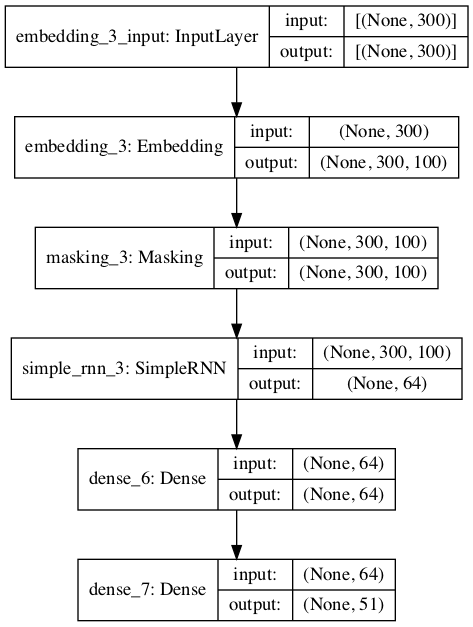

In [149]:
# Compile the model
model.compile(
    optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# summarize the model
print(model.summary())
plot_model(model, to_file='model.png', show_shapes=True)

In [134]:
%%time
# fit the model
X_train, X_test, y_train, y_test = train_test_split(padded_docs, labels_encoded, test_size=0.1)
model.fit(X_train, y_train, validation_split = 0.1, epochs=10, verbose=1)

Epoch 1/10
1554/1554 [==============================] - 103s 65ms/step - loss: 2.1815 - accuracy: 0.4631 - val_loss: 1.3299 - val_accuracy: 0.6579
Epoch 2/10
1554/1554 [==============================] - 99s 64ms/step - loss: 1.2060 - accuracy: 0.6903 - val_loss: 1.2020 - val_accuracy: 0.7007
Epoch 3/10
1554/1554 [==============================] - 95s 61ms/step - loss: 1.0999 - accuracy: 0.7158 - val_loss: 1.0562 - val_accuracy: 0.7347
Epoch 4/10
1554/1554 [==============================] - 95s 61ms/step - loss: 0.9773 - accuracy: 0.7504 - val_loss: 1.0417 - val_accuracy: 0.7423
Epoch 5/10
1554/1554 [==============================] - 94s 61ms/step - loss: 0.9095 - accuracy: 0.7665 - val_loss: 1.0760 - val_accuracy: 0.7311
Epoch 6/10
1554/1554 [==============================] - 94s 60ms/step - loss: 0.8737 - accuracy: 0.7704 - val_loss: 0.9502 - val_accuracy: 0.7655
Epoch 7/10
1554/1554 [==============================] - 93s 60ms/step - loss: 0.8335 - accuracy: 0.7835 - val_loss: 0.9461 

In [135]:
# evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print('Accuracy: %f' % (accuracy*100))

192/192 [==============================] - 3s 17ms/step - loss: 0.8774 - accuracy: 0.7704
Accuracy: 77.037156


##### Logistic Regression

In [137]:
%%time
X_train, X_test, y_train, y_test = train_test_split(padded_docs, labels_encoded, test_size=0.2, stratify = labels_encoded)
lr = OneVsRestClassifier(LogisticRegression(penalty='l2'))
lr.fit(X_train, y_train)
lr.score(X_test,y_test)

CPU times: user 4min 20s, sys: 12.2 s, total: 4min 32s
Wall time: 1min 10s


0.01817292804172439

##### LSTM

In [193]:
VOCAB_SIZE = int(len(tokenizer.word_index) * 1.1)
tokenizer, padded_docs, embedding_matrix, MAX_SEQUENCE_LENGTH = word_embedding(df['description'])

Loaded 400000 word vectors.


In [195]:
def make_lstm_classification_model(embedding_matrix,MAX_SEQUENCE_LENGTH,plot=False):
    
    model =  Sequential()
    model.add(Embedding(VOCAB_SIZE, 100, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False))
    model.add(Masking(mask_value=0.0)) # masking layer, masks any words that don't have an embedding as 0s.
    model.add(LSTM(units=32, input_shape=(1, MAX_SEQUENCE_LENGTH)))
    model.add(Dense(64))
    model.add(Dense(51, activation='softmax'))
    
    # Compile the model
    model.compile(
    optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    # summarize the model
    model.summary()
    
    if plot:
        plot_model(model, to_file='model.png', show_shapes=True)
    return model

In [155]:
lstm = make_lstm_classification_model(embedding_matrix,MAX_SEQUENCE_LENGTH,plot=True)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 300, 100)          2877800   
_________________________________________________________________
masking_5 (Masking)          (None, 300, 100)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                17024     
_________________________________________________________________
dense_10 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_11 (Dense)             (None, 51)                3315      
Total params: 2,900,251
Trainable params: 22,451
Non-trainable params: 2,877,800
_________________________________________________________________


In [156]:
%%time
# fit the model
## dense=64
X_train, X_test, y_train, y_test = train_test_split(padded_docs, labels_encoded, test_size=0.2)
lstm.fit(X_train, y_train, validation_split = 0.1, epochs=10, verbose=1)

Epoch 1/10
1381/1381 [==============================] - 123s 88ms/step - loss: 2.2996 - accuracy: 0.4430 - val_loss: 1.0614 - val_accuracy: 0.7315
Epoch 2/10
1381/1381 [==============================] - 118s 86ms/step - loss: 1.0081 - accuracy: 0.7470 - val_loss: 0.8503 - val_accuracy: 0.7900
Epoch 3/10
1381/1381 [==============================] - 118s 85ms/step - loss: 0.7901 - accuracy: 0.8010 - val_loss: 0.7929 - val_accuracy: 0.8000
Epoch 4/10
1381/1381 [==============================] - 119s 86ms/step - loss: 0.6896 - accuracy: 0.8230 - val_loss: 0.7071 - val_accuracy: 0.8213
Epoch 5/10
1381/1381 [==============================] - 120s 87ms/step - loss: 0.6361 - accuracy: 0.8357 - val_loss: 0.6709 - val_accuracy: 0.8291
Epoch 6/10
1381/1381 [==============================] - 118s 86ms/step - loss: 0.5793 - accuracy: 0.8502 - val_loss: 0.6515 - val_accuracy: 0.8340
Epoch 7/10
1381/1381 [==============================] - 119s 86ms/step - loss: 0.5409 - accuracy: 0.8575 - val_loss: 0

In [157]:
# evaluate the model
loss, accuracy = lstm.evaluate(X_test, y_test, verbose=1)
print('Accuracy: %f' % (accuracy*100))

384/384 [==============================] - 6s 16ms/step - loss: 0.6171 - accuracy: 0.8437
Accuracy: 84.369653


#### use 'description','details', 'name', 'category' and 'attribute_pair'

##### Deep learning NN: 96.145%

In [201]:
X = df['description']+' '+df['name']+' '+df['details']+' '+ df['attribute_pair']+' '+df['brand_category']
# not pre_trained embedding
tokenizer, padded_docs, MAX_SEQUENCE_LENGTH = word_embedding_2(X)
VOCAB_SIZE = int(len(tokenizer.word_index) * 1.1)
EMBEDDING_SIZE = 100

In [12]:
# define the model
def DNN(VOCAB_SIZE,EMBEDDING_SIZE,MAX_SEQUENCE_LENGTH):
    model = Sequential()
    model.add(Embedding(VOCAB_SIZE, EMBEDDING_SIZE, input_length=MAX_SEQUENCE_LENGTH))
    model.add(Flatten()) 
    model.add(Dense(51, activation='sigmoid')) 
    return model

In [202]:
model = DNN(VOCAB_SIZE,EMBEDDING_SIZE,MAX_SEQUENCE_LENGTH)

In [203]:
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc']) # accuracy
# summarize the model
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 300, 100)          3663800   
_________________________________________________________________
flatten_3 (Flatten)          (None, 30000)             0         
_________________________________________________________________
dense_19 (Dense)             (None, 51)                1530051   
Total params: 5,193,851
Trainable params: 5,193,851
Non-trainable params: 0
_________________________________________________________________


In [204]:
X_train, X_test, y_train, y_test = train_test_split(padded_docs, labels_encoded, test_size=0.2,stratify=labels_encoded)
# fit the model
model.fit(X_train, y_train, validation_split = 0.1, epochs=20, verbose=1)
# evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=1) # it's on training data
print('-----------------------')
print('Accuracy: %f' % (accuracy*100))

Epoch 1/20
1381/1381 [==============================] - 34s 24ms/step - loss: 0.0577 - acc: 0.5718 - val_loss: 0.0116 - val_acc: 0.9273
Epoch 2/20
1381/1381 [==============================] - 35s 25ms/step - loss: 0.0070 - acc: 0.9607 - val_loss: 0.0080 - val_acc: 0.9536
Epoch 3/20
1381/1381 [==============================] - 34s 25ms/step - loss: 0.0031 - acc: 0.9831 - val_loss: 0.0073 - val_acc: 0.9580
Epoch 4/20
1381/1381 [==============================] - 35s 25ms/step - loss: 0.0018 - acc: 0.9893 - val_loss: 0.0072 - val_acc: 0.9611
Epoch 5/20
1381/1381 [==============================] - 35s 25ms/step - loss: 0.0011 - acc: 0.9923 - val_loss: 0.0074 - val_acc: 0.9603
Epoch 6/20
1381/1381 [==============================] - 35s 25ms/step - loss: 8.3803e-04 - acc: 0.9944 - val_loss: 0.0079 - val_acc: 0.9601
Epoch 7/20
1381/1381 [==============================] - 35s 25ms/step - loss: 6.2315e-04 - acc: 0.9965 - val_loss: 0.0085 - val_acc: 0.9593
Epoch 8/20
1381/1381 [==================

In [211]:
## DNN: using pre_trained embeddings

tokenizer, padded_docs, embedding_matrix, MAX_SEQUENCE_LENGTH = word_embedding(X)
vocab_size = int(len(tokenizer.word_index) * 1.1)
model = Sequential()
e = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False)
model.add(e)
model.add(Flatten())
model.add(Dense(51, activation='sigmoid'))

Loaded 400000 word vectors.


In [212]:
%%time
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 300, 100)          3663800   
_________________________________________________________________
flatten_4 (Flatten)          (None, 30000)             0         
_________________________________________________________________
dense_22 (Dense)             (None, 51)                1530051   
Total params: 5,193,851
Trainable params: 1,530,051
Non-trainable params: 3,663,800
_________________________________________________________________
None
CPU times: user 8.43 ms, sys: 1.38 ms, total: 9.81 ms
Wall time: 8.73 ms


In [213]:
%%time
# fit the model
X_train, X_test, y_train, y_test = train_test_split(padded_docs, labels_encoded, test_size=0.2,stratify=labels_encoded)
model.fit(X_train, y_train, validation_split = 0.1, epochs=10, verbose=1)

Epoch 1/10
1381/1381 [==============================] - 7s 5ms/step - loss: 0.0595 - acc: 0.6057 - val_loss: 0.0234 - val_acc: 0.8387
Epoch 2/10
1381/1381 [==============================] - 6s 5ms/step - loss: 0.0153 - acc: 0.9130 - val_loss: 0.0208 - val_acc: 0.8609
Epoch 3/10
1381/1381 [==============================] - 7s 5ms/step - loss: 0.0105 - acc: 0.9461 - val_loss: 0.0205 - val_acc: 0.8713
Epoch 4/10
1381/1381 [==============================] - 7s 5ms/step - loss: 0.0084 - acc: 0.9587 - val_loss: 0.0209 - val_acc: 0.8753
Epoch 5/10
1381/1381 [==============================] - 7s 5ms/step - loss: 0.0070 - acc: 0.9671 - val_loss: 0.0218 - val_acc: 0.8725
Epoch 6/10
1381/1381 [==============================] - 6s 5ms/step - loss: 0.0061 - acc: 0.9727 - val_loss: 0.0224 - val_acc: 0.8776
Epoch 7/10
1381/1381 [==============================] - 7s 5ms/step - loss: 0.0055 - acc: 0.9750 - val_loss: 0.0229 - val_acc: 0.8808
Epoch 8/10
1381/1381 [==============================] - 7s 5ms

In [214]:
# evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=1) # it's on training data
print('Accuracy: %f' % (accuracy*100))

384/384 [==============================] - 1s 2ms/step - loss: 0.0269 - acc: 0.8697
Accuracy: 86.969274


In [220]:
model.predict(X_test).shape

(12271, 51)

##### RNN: 80.278%

Loaded 400000 word vectors.
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 300, 100)          3663800   
_________________________________________________________________
masking_7 (Masking)          (None, 300, 100)          0         
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, 64)                10560     
_________________________________________________________________
dense_17 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_18 (Dense)             (None, 51)                3315      
Total params: 3,681,835
Trainable params: 18,035
Non-trainable params: 3,663,800
_________________________________________________________________
None


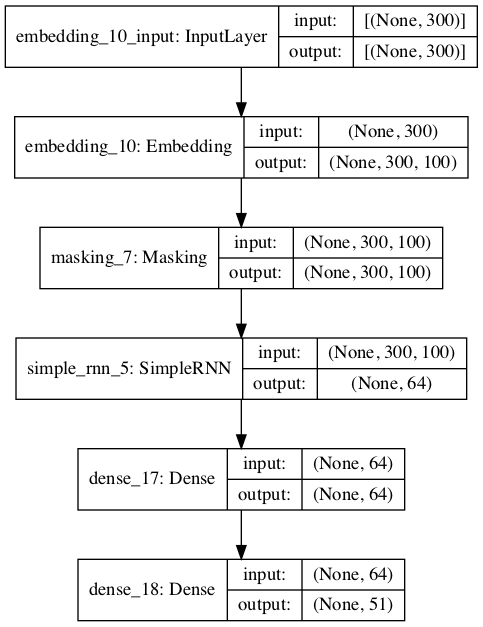

In [196]:
## using pre-trained embeddings
tokenizer, padded_docs, embedding_matrix, MAX_SEQUENCE_LENGTH = word_embedding(X)
model = RNN(embedding_matrix,MAX_SEQUENCE_LENGTH)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())
plot_model(model, to_file='model.png', show_shapes=True)

In [198]:
%%time
# fit the model
X_train, X_test, y_train, y_test = train_test_split(padded_docs, labels_encoded, test_size=0.2,stratify=labels_encoded)
model.fit(X_train, y_train, validation_split = 0.1, epochs=10, verbose=1)

Epoch 1/10
1381/1381 [==============================] - 74s 54ms/step - loss: 1.2037 - accuracy: 0.6838 - val_loss: 1.0808 - val_accuracy: 0.7101
Epoch 2/10
1381/1381 [==============================] - 79s 58ms/step - loss: 1.0462 - accuracy: 0.7217 - val_loss: 0.9708 - val_accuracy: 0.7354
Epoch 3/10
1381/1381 [==============================] - 80s 58ms/step - loss: 0.9543 - accuracy: 0.7447 - val_loss: 0.9181 - val_accuracy: 0.7594
Epoch 4/10
1381/1381 [==============================] - 85s 61ms/step - loss: 0.8707 - accuracy: 0.7670 - val_loss: 0.9698 - val_accuracy: 0.7460
Epoch 5/10
1381/1381 [==============================] - 83s 60ms/step - loss: 0.8220 - accuracy: 0.7801 - val_loss: 0.8465 - val_accuracy: 0.7725
Epoch 6/10
1381/1381 [==============================] - 83s 60ms/step - loss: 0.7755 - accuracy: 0.7922 - val_loss: 0.8447 - val_accuracy: 0.7729
Epoch 7/10
1381/1381 [==============================] - 88s 64ms/step - loss: 0.7473 - accuracy: 0.7964 - val_loss: 0.7946 -

In [199]:
# evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=1) # it's on training data
print('Accuracy: %f' % (accuracy*100))

384/384 [==============================] - 5s 14ms/step - loss: 0.7677 - accuracy: 0.8028
Accuracy: 80.278707


##### LSTM: 92.83%

Loaded 400000 word vectors.
Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 300, 100)          3663800   
_________________________________________________________________
masking_8 (Masking)          (None, 300, 100)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                17024     
_________________________________________________________________
dense_20 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_21 (Dense)             (None, 51)                3315      
Total params: 3,686,251
Trainable params: 22,451
Non-trainable params: 3,663,800
_________________________________________________________________
Model: "sequential_15"
_____________________________________________________

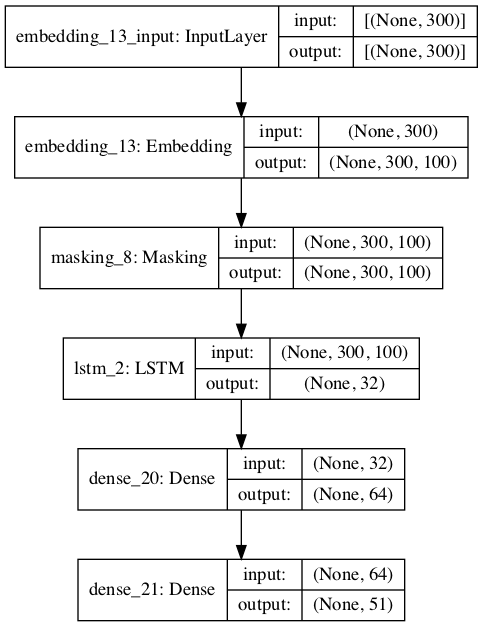

In [207]:
tokenizer, padded_docs, embedding_matrix, MAX_SEQUENCE_LENGTH = word_embedding(X)
lstm= make_lstm_classification_model(embedding_matrix,MAX_SEQUENCE_LENGTH,plot=False)
lstm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(lstm.summary())
plot_model(lstm, to_file='model.png', show_shapes=True)

In [208]:
%%time
# fit the model
X_train, X_test, y_train, y_test = train_test_split(padded_docs, labels_encoded, test_size=0.2,stratify=labels_encoded)
lstm.fit(X_train, y_train, validation_split = 0.1, epochs=10, verbose=1)

Epoch 1/10
1381/1381 [==============================] - 123s 87ms/step - loss: 2.3101 - accuracy: 0.4346 - val_loss: 0.9073 - val_accuracy: 0.7645
Epoch 2/10
1381/1381 [==============================] - 121s 87ms/step - loss: 0.8083 - accuracy: 0.7903 - val_loss: 0.6460 - val_accuracy: 0.8346
Epoch 3/10
1381/1381 [==============================] - 121s 87ms/step - loss: 0.5624 - accuracy: 0.8557 - val_loss: 0.4938 - val_accuracy: 0.8794
Epoch 4/10
1381/1381 [==============================] - 129s 94ms/step - loss: 0.4170 - accuracy: 0.8929 - val_loss: 0.4246 - val_accuracy: 0.8951
Epoch 5/10
1381/1381 [==============================] - 127s 92ms/step - loss: 0.3534 - accuracy: 0.9113 - val_loss: 0.3670 - val_accuracy: 0.9171
Epoch 6/10
1381/1381 [==============================] - 138s 100ms/step - loss: 0.3009 - accuracy: 0.9237 - val_loss: 0.3644 - val_accuracy: 0.9138
Epoch 7/10
1381/1381 [==============================] - 121s 88ms/step - loss: 0.2795 - accuracy: 0.9284 - val_loss: 

In [209]:
# evaluate the model
loss, accuracy = lstm.evaluate(X_test, y_test, verbose=1) # it's on training data
print('Accuracy: %f' % (accuracy*100))

384/384 [==============================] - 7s 17ms/step - loss: 0.2980 - accuracy: 0.9283
Accuracy: 92.828619


#### use 'description','details', 'name', 'category', 'attribute_pair' and created features

In [226]:
# combine data
data_X = pd.concat([X,combined],axis=1).rename(columns={0:'text'})
y = labels_encoded
data_X.head(1)

,text,is_beach,is_city,is_holiday,is_romance,is_chic,is_comfortable,is_weekday,is_asymmetrical,is_timeless,...,material_100 watersnake,material_100 weave,material_100 white,material_100 wood,material_100 wool,material_100 woolproduct,material_100 year,material_100 yummy,material_100 ï,material_UNKNOWN_TOKEN
0,signature khadi shirt available black white ea...,True,True,False,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,1


In [244]:
X_train, X_test, y_train, y_test = train_test_split(data_X, y, test_size=0.2,stratify=y,random_state=42)

preprocess text input

In [256]:
X1_train = X_train['text'].values
X1_test = X_test['text'].values

In [257]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X1_train)

X1_train = tokenizer.texts_to_sequences(X1_train)
X1_test = tokenizer.texts_to_sequences(X1_test)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 200

X1_train = pad_sequences(X1_train, padding='post', maxlen=maxlen)
X1_test = pad_sequences(X1_test, padding='post', maxlen=maxlen)

embeddings_dictionary = dict()

glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions

glove_file.close()

embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

preprocess categorical input

In [258]:
X2_train = X_train.drop(columns=['text']).values
X2_test = X_test.drop(columns=['text']).values

In [268]:
X2_test = X2_test.astype(int)
X2_train = X2_train.astype(int)

put these 2 inputs into model

In [269]:
input_1 = Input(shape=(maxlen,))
input_2 = Input(shape=(686,))

# 1st submodel accepting data from 1st input layer
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(input_1)
LSTM_Layer_1 = LSTM(128)(embedding_layer)

# 2nd submodel accepting data from 2nd input layer
dense_layer_1 = Dense(64, activation='relu')(input_2)
dense_layer_2 = Dense(64, activation='relu')(dense_layer_1)

# concatenate the output from the first submodel with the output from the second submodel
concat_layer = Concatenate()([LSTM_Layer_1, dense_layer_2])
dense_layer_3 = Dense(64, activation='relu')(concat_layer)
output = Dense(51, activation='softmax')(dense_layer_3)
model = Model(inputs=[input_1, input_2], outputs=output)

# model summary
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
print(model.summary())

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 200)]        0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, 686)]        0                                            
__________________________________________________________________________________________________
embedding_21 (Embedding)        (None, 200, 100)     3068500     input_11[0][0]                   
__________________________________________________________________________________________________
dense_43 (Dense)                (None, 64)           43968       input_12[0][0]                   
____________________________________________________________________________________________

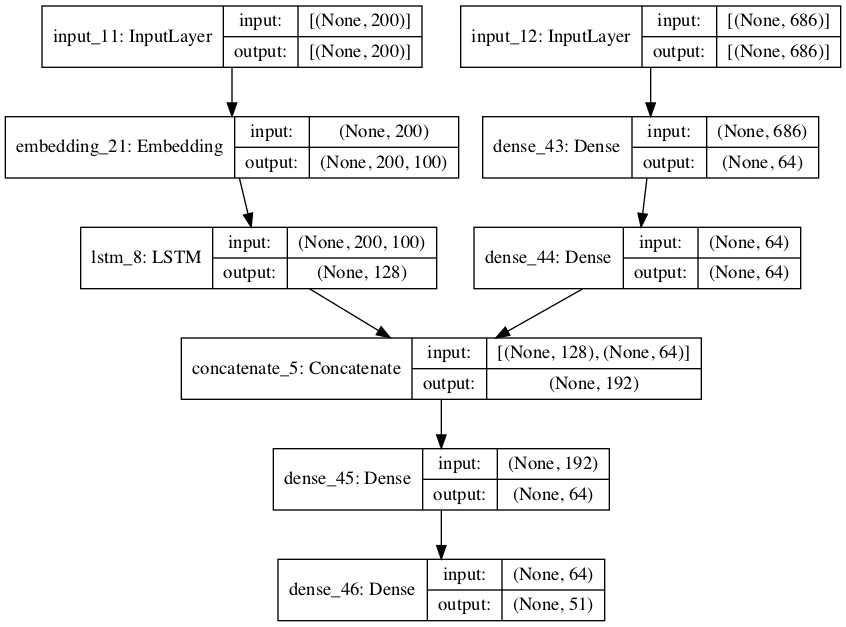

In [270]:
plot_model(model, to_file='model_plot3.png', show_shapes=True, show_layer_names=True)

In [271]:
%%time
history = model.fit(x=[X1_train, X2_train], y=y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.1)

Epoch 1/10
346/346 [==============================] - 101s 285ms/step - loss: 3.2367 - acc: 0.2124 - val_loss: 2.2633 - val_acc: 0.4202
Epoch 2/10
346/346 [==============================] - 96s 278ms/step - loss: 2.1376 - acc: 0.4506 - val_loss: 1.8601 - val_acc: 0.5005
Epoch 3/10
346/346 [==============================] - 105s 302ms/step - loss: 1.7841 - acc: 0.5146 - val_loss: 1.5785 - val_acc: 0.5661
Epoch 4/10
346/346 [==============================] - 113s 325ms/step - loss: 1.5009 - acc: 0.5824 - val_loss: 1.4585 - val_acc: 0.5745
Epoch 5/10
346/346 [==============================] - 101s 293ms/step - loss: 1.3182 - acc: 0.6289 - val_loss: 1.1579 - val_acc: 0.6710
Epoch 6/10
346/346 [==============================] - 120s 347ms/step - loss: 1.1445 - acc: 0.6841 - val_loss: 0.9410 - val_acc: 0.7362
Epoch 7/10
346/346 [==============================] - 115s 332ms/step - loss: 0.9445 - acc: 0.7409 - val_loss: 0.8558 - val_acc: 0.7592
Epoch 8/10
346/346 [=============================

In [272]:
score = model.evaluate(x=[X1_test, X2_test], y=y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

384/384 [==============================] - 14s 35ms/step - loss: 0.6179 - acc: 0.8432
Test Score: 0.6179152727127075
Test Accuracy: 0.8432075381278992


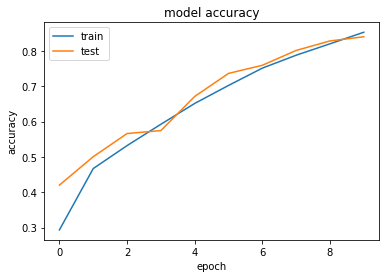

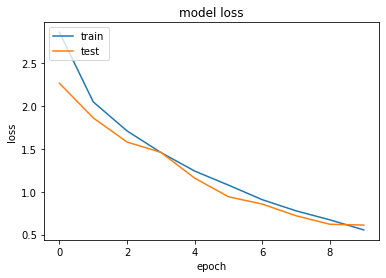

In [273]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

### Final Model: 96.398%

Based on above attempts, DNN model performs the best after word-embedding. Therefore, we decided to use it as our final model.

In [13]:
%%time
X = df['description']+' '+df['name']+' '+df['details']+' '+ df['attribute_pair']+' '+df['brand_category']

tokenizer, padded_docs, MAX_SEQUENCE_LENGTH = word_embedding_2(X)
VOCAB_SIZE = int(len(tokenizer.word_index) * 1.1)
EMBEDDING_SIZE = 100

final_dnn = DNN(VOCAB_SIZE,EMBEDDING_SIZE,MAX_SEQUENCE_LENGTH)
final_dnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
X_train, X_test, y_train, y_test = train_test_split(padded_docs, labels_encoded, test_size=0.2,stratify=labels_encoded,random_state=2021)
# fit the model
final_dnn.fit(X_train, y_train, validation_split = 0.1, epochs=20, verbose=1)

Epoch 1/20
1381/1381 [==============================] - 34s 24ms/step - loss: 0.0580 - acc: 0.5701 - val_loss: 0.0114 - val_acc: 0.9328
Epoch 2/20
1381/1381 [==============================] - 33s 24ms/step - loss: 0.0071 - acc: 0.9606 - val_loss: 0.0079 - val_acc: 0.9529
Epoch 3/20
1381/1381 [==============================] - 34s 25ms/step - loss: 0.0031 - acc: 0.9826 - val_loss: 0.0067 - val_acc: 0.9582
Epoch 4/20
1381/1381 [==============================] - 34s 24ms/step - loss: 0.0019 - acc: 0.9894 - val_loss: 0.0067 - val_acc: 0.9619
Epoch 5/20
1381/1381 [==============================] - 33s 24ms/step - loss: 0.0013 - acc: 0.9919 - val_loss: 0.0069 - val_acc: 0.9611
Epoch 6/20
1381/1381 [==============================] - 33s 24ms/step - loss: 8.8483e-04 - acc: 0.9941 - val_loss: 0.0082 - val_acc: 0.9595
Epoch 7/20
1381/1381 [==============================] - 33s 24ms/step - loss: 6.8243e-04 - acc: 0.9952 - val_loss: 0.0077 - val_acc: 0.9603
Epoch 8/20
1381/1381 [==================

In [331]:
# evaluate the model
loss, accuracy = final_dnn.evaluate(X_test, y_test, verbose=1) # it's on training data

print('-----------------------')
print('Accuracy: %f' % (accuracy*100))

384/384 [==============================] - 1s 2ms/step - loss: 0.0115 - acc: 0.9640
-----------------------
Accuracy: 96.398014


In [15]:
prediction = final_dnn.predict_classes(X_test)

In [22]:
prediction

array([16, 50,  1, ..., 21, 50, 36])

In [16]:
predict = encoder.inverse_transform(prediction)
predict

array(['Chufy', 'other', '7 For All Mankind', ..., 'Cynthia Rowley',
       'other', 'Outerknown'], dtype=object)

In [17]:
actual = y_test.argmax(1)
actual_brand = encoder.inverse_transform(actual)

In [18]:
actual_brand

array(['Chufy', 'other', '7 For All Mankind', ..., 'Cynthia Rowley',
       'other', 'Outerknown'], dtype=object)

In [19]:
results = pd.DataFrame({'actual':actual_brand,'predict':predict})
results

,actual,predict
0,Chufy,Chufy
1,other,other
2,7 For All Mankind,7 For All Mankind
3,7 For All Mankind,7 For All Mankind
4,7 For All Mankind,7 For All Mankind
...,...,...
12266,7 For All Mankind,7 For All Mankind
12267,Misa,Misa
12268,Cynthia Rowley,Cynthia Rowley
12269,other,other


In [20]:
results['predict_true']=(results['actual']==results['predict'])

In [21]:
results.groupby(['actual'])['predict_true'].mean()

actual
6397                     0.953846
7 For All Mankind        0.993896
A.L.C.                   0.940334
ANINE BING               0.779412
ASTR the Label           0.958763
ATP Atelier              1.000000
Aesther Ekme             1.000000
Alo Yoga                 0.961905
Ancient Greek Sandals    0.983871
Andrea Iyamah            0.917808
Araks                    0.986111
BROCHU WALKER            0.965000
Banjanan                 0.980769
Batsheva                 0.979381
Cariuma                  0.969231
Christina Lehr           0.833333
Chufy                    0.966942
Ciao Lucia               0.984375
Citizens of Humanity     0.875000
Clare V.                 0.972826
Collina Strada           0.970000
Cynthia Rowley           0.899628
EMME PARSONS             0.943396
Eleven Six               0.982143
Esquivel                 0.881356
Faherty                  0.946058
Frame                    0.555556
Gigi Burris              0.918033
Intentionally Blank      0.905325
Janessa